In [1]:
from quaternions import *
from networks import *
from sim_helpers import *
from liegroups.numpy import SO3
import torch
from convex_layers import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

In [31]:
path = 'saved_data/synthetic/synthetic_wahba_model_12-13-2019-00-41-44.pt'
checkpoint = torch.load(path)
args = checkpoint['args']
device = torch.device('cpu')
tensor_type = torch.double
model = QuatNet().to(device=device, dtype=tensor_type)
print('Loading data...')
model.load_state_dict(checkpoint['model_rep'], strict=False)
print('Done')

Loading data...
Done


In [32]:
train_data, test_data = create_experimental_data(5, 100, args.matches_per_sample, sigma=args.sim_sigma, device=device, dtype=tensor_type)

In [33]:
def l2_diff(a, b):
    return (a - b).norm(dim=1)
def acos_diff(a, b):
    return (180./3.1415)*torch.acos((a*b).sum(dim=1, keepdim=True)).squeeze()

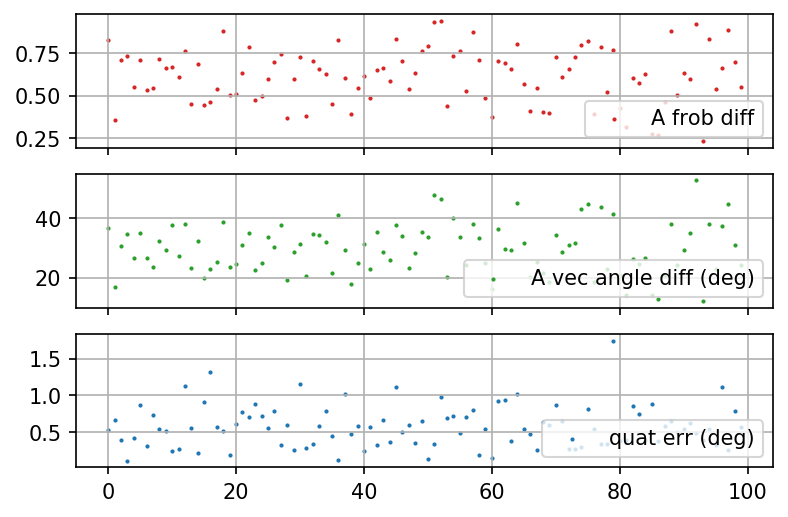

In [35]:
def _scatter(ax, x, y, title, color='tab:red'):
    ax.scatter(x, y, color=color, s=1, label=title)
    ax.grid()
    ax.legend(loc='lower right')
    return

model.eval()
i = torch.arange(0,test_data.x.shape[0])
with torch.no_grad():
    A_vec = model.A_net.forward(test_data.x[i])
    q_est = model.forward(test_data.x[i]).squeeze()
    
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row')

A_vec_psd = convert_Avec_to_Avec_psd(A_vec_pred, normalize=True)
A_pred = convert_Avec_to_A(A_vec_psd)
A_wahba = test_data.A_prior[i]
A_wahba = A_wahba / A_wahba.norm(dim=[1,2], keepdim=True)
A_wahba_vec = convert_A_to_Avec(A_wahba)

_scatter(ax[0], i, (A_pred - A_wahba).norm(dim=[1,2]).numpy(), 'A frob diff', color='tab:red')
_scatter(ax[1], i, acos_diff(A_vec_psd, A_wahba_vec).numpy(), 'A vec angle diff (deg)', color='tab:green')
_scatter(ax[2], i, quat_angle_diff(q_est, test_data.q[i], reduce=False).numpy(), 'quat err (deg)', color='tab:blue')
plt.show()

In [40]:
el, ev = np.linalg.eig(A_pred[15].numpy())
print(el)
#print(ev)
#print(q_est[0])


[0.18459445 0.6828018  0.6212011  0.41700658]


In [41]:
el, ev = np.linalg.eig(A_wahba[15].numpy())
print(el)

#print(np.linalg.eig(test_data.A_prior[15].numpy()))
#print(ev)

[6.37268016e-13 5.97393623e-01 5.77027006e-01 5.56920724e-01]


In [20]:
matches = 36
sigma = 1e-10
#sigma_vec = sigma*np.random.randn(matches)
sigma_vec = sigma*np.ones(matches)

#sigma_vec[:int(matches/2)] *= np.random.randn(int(matches/2)) #Artificially scale half the noise

C, x_1, x_2 = gen_sim_data_grid(matches, sigma_vec, torch_vars=False, shuffle_points=False)
print(x_1)
A = build_A(x_1, x_2, sigma_2=sigma_vec**2)
A = A/np.linalg.norm(A)
el, ev = np.linalg.eig(A)
print(el)
print(ev)
print(np.linalg.matrix_rank(A))

[[ 0.63400617 -0.50053118  0.58949531]
 [-0.43213428 -0.83884891 -0.33104754]
 [-0.75789485 -0.1451288  -0.63602912]
 [-0.68527397 -0.40171233 -0.60747575]
 [-0.45519473  0.78624545 -0.41787062]
 [-0.36277719  0.8948504  -0.26006821]
 [-0.63969571 -0.54492598 -0.54207478]
 [-0.56494051  0.67254822 -0.47803882]
 [-0.70603423  0.55581418 -0.43884653]
 [-0.76030451 -0.04853007 -0.64775141]
 [ 0.58374957  0.58374957  0.564334  ]
 [ 0.25406384 -0.95762526  0.13566658]
 [-0.67915138  0.35574596 -0.64202664]
 [-0.63969571  0.54492598 -0.54207478]
 [-0.55713207 -0.67442303 -0.48451773]
 [-0.37802641  0.88206162 -0.28118201]
 [-0.34674289  0.88612071 -0.30750522]
 [ 0.14101309  0.9870916   0.07593081]
 [-0.61994157 -0.56603361 -0.54339526]
 [-0.38384531  0.84445969 -0.37356473]
 [-0.74248167  0.09518996 -0.66306851]
 [ 0.63541497  0.59442046  0.49286117]
 [-0.06952961 -0.99659114 -0.04440423]
 [-0.63310758  0.69487417 -0.34106404]
 [-0.6946191   0.33444623 -0.6369066 ]
 [ 0.55853405  0.78194767

In [92]:
matches = 16
C = SO3.exp(np.random.randn(3)).as_matrix()
#v = normalized(np.random.randn(1, 3))
#x_1 = np.concatenate((v, v))
x_1 = normalized(np.random.randn(matches, 3))
x_2 = C.dot(x_1.T).T 
A = build_A(x_1, x_2, sigma_2=np.ones(matches))
A = A / np.linalg.norm(A)

print(A)
el, ev = np.linalg.eig(A)
print(el)
#print(ev)
print(np.linalg.det(A))
print(np.linalg.matrix_rank(A))

# B = 4*np.eye(4) + 2*Omega_l(pure_quat(x_2[0])).dot(
#             Omega_r(pure_quat(x_1[0]))) + 2*Omega_l(pure_quat(x_2[1])).dot(
#             Omega_r(pure_quat(x_1[1])))
# B = B / np.linalg.norm(B)
# print(B)
# print(np.linalg.eig(B))


[[ 6.25161850e-01  1.73726252e-04 -9.73207795e-03  7.03499710e-02]
 [ 1.73726252e-04  2.97097683e-01 -2.72019998e-02  1.96583693e-01]
 [-9.73207795e-03 -2.72019998e-02  6.32341277e-01  6.92308914e-02]
 [ 7.03499710e-02  1.96583693e-01  6.92308914e-02  1.50354203e-01]]
[0.         0.42447614 0.63837725 0.64210162]
9.006943421033043e-19
3


In [280]:
matches = 100
C, x_1, x_2 = gen_sim_data(matches, 1e-1*np.ones(matches), torch_vars=True, shuffle_points=True)
x = torch.empty(1, 2, matches, 3, dtype=torch.double)
x[0,0,:,:] = x_1
x[0,1,:,:] = x_2
q_est = model.forward(x).squeeze()
q_gt = rotmat_to_quat(C, ordering='xyzw')
print(quat_angle_diff(q_est, q_gt))

C_horn = solve_horn(x_1.numpy(), x_2.numpy())
print(quat_angle_diff(rotmat_to_quat(torch.from_numpy(C_horn), ordering='xyzw'), q_gt))

tensor(2.8169, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(2.2020, dtype=torch.float64)


In [275]:
convert_Avec_to_A(torch.arange(10))

tensor([[0, 1, 2, 3],
        [1, 4, 5, 6],
        [2, 5, 7, 8],
        [3, 6, 8, 9]])